In [9]:
!pip install transformers==4.30.2
!pip install torch==2.0.1
!pip install gradio==3.34.0
!pip install peft==0.4.0

Dataset shape: (10749, 37)

Sample data:
                                                text  Unnamed: 1  Unnamed: 2  \
0                                    That game hurt.         NaN         NaN   
1   >sexuality shouldn’t be a grouping category I...         NaN         NaN   
2     You do right, if you don't care then fuck 'em!         NaN         NaN   
3                                 Man I love reddit.         NaN         NaN   
4  [NAME] was nowhere near them, he was by the Fa...         NaN         NaN   

   Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   admiration  

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


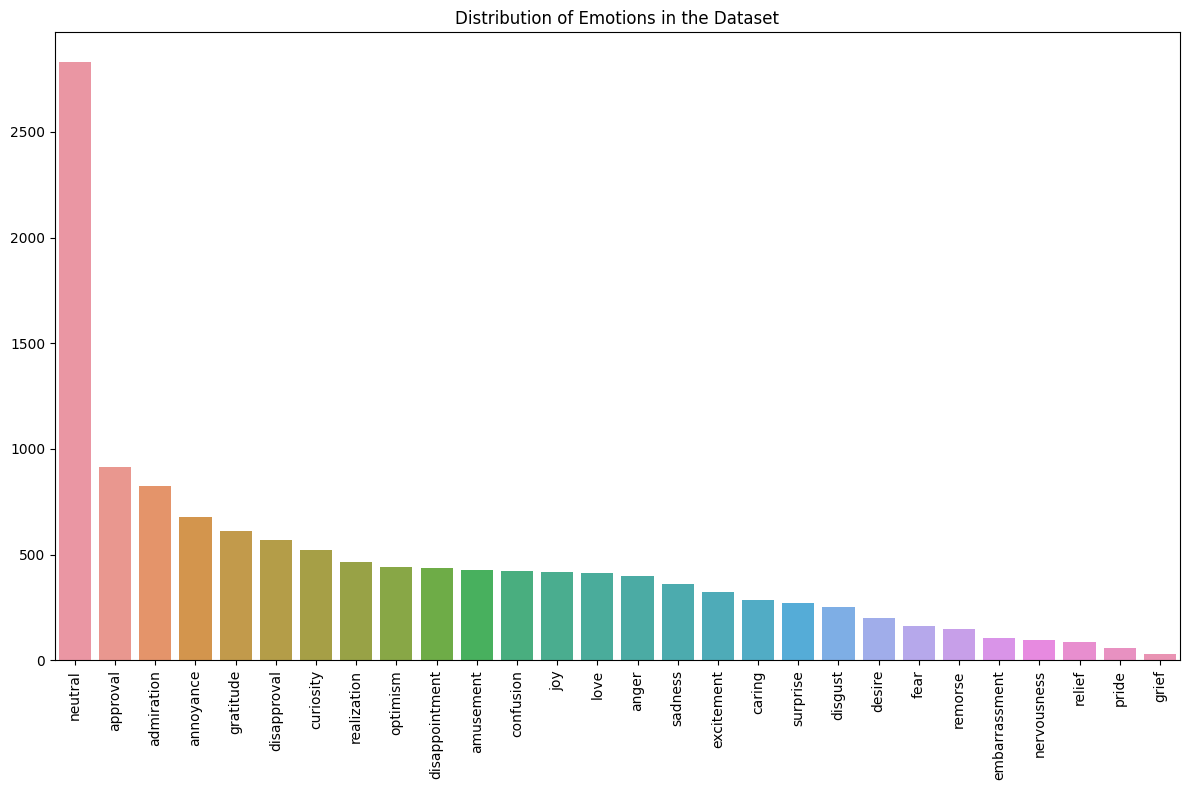


Number of emotions per text:
0     154
1    8720
2    1626
3     221
4      21
5       1
6       4
7       2
Name: count, dtype: int64


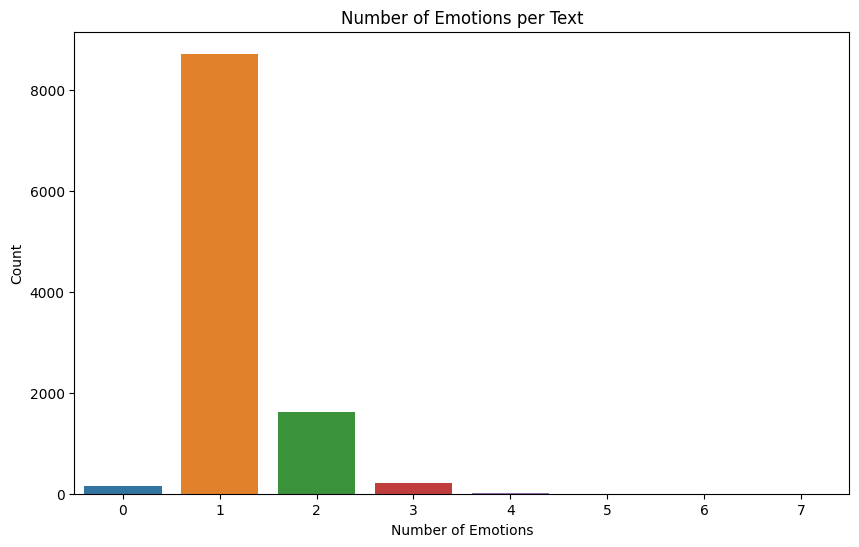


Happy emotions: ['admiration', 'amusement', 'approval', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief']
Sad emotions: ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'grief', 'remorse', 'sadness']
Neutral emotions: ['confusion', 'curiosity', 'realization', 'surprise', 'neutral']
Stress-related emotions: ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness']

Training set: 8599 samples
Testing set: 2150 samples

Data preparation completed!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DebertaTokenizer, DebertaForSequenceClassification
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Load the dataset
df = pd.read_csv('/kaggle/input/goemotion-trimmed/goemotions_trimed.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nSample data:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Count distribution of emotions
emotion_columns = df.columns[9:].tolist()  # All columns except 'text'
emotion_counts = df[emotion_columns].sum().sort_values(ascending=False)

print("\nEmotion distribution:")
print(emotion_counts)

# Visualize emotion distribution
plt.figure(figsize=(12, 8))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.xticks(rotation=90)
plt.title('Distribution of Emotions in the Dataset')
plt.tight_layout()
plt.show()

# Check multi-label distribution
label_counts = df[emotion_columns].sum(axis=1).value_counts().sort_index()
print("\nNumber of emotions per text:")
print(label_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Number of Emotions per Text')
plt.xlabel('Number of Emotions')
plt.ylabel('Count')
plt.show()

# Define emotion groups for metrics calculation
happy_emotions = ['admiration', 'amusement', 'approval', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief']
sad_emotions = ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'grief', 'remorse', 'sadness']
neutral_emotions = ['confusion', 'curiosity', 'realization', 'surprise', 'neutral']
stress_emotions = ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness']

# Print the emotion groups
print("\nHappy emotions:", happy_emotions)
print("Sad emotions:", sad_emotions)
print("Neutral emotions:", neutral_emotions)
print("Stress-related emotions:", stress_emotions)

# Split the dataset
X = df['text'].values
y = df[emotion_columns].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Save the emotion columns for later use
import pickle
with open('emotion_columns.pkl', 'wb') as f:
    pickle.dump(emotion_columns, f)
with open('emotion_groups.pkl', 'wb') as f:
    pickle.dump({
        'happy': happy_emotions,
        'sad': sad_emotions,
        'neutral': neutral_emotions,
        'stress': stress_emotions
    }, f)

print("\nData preparation completed!")


In [3]:
# Model Definition

# Custom Dataset class for the emotion detection task
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# Custom model for multi-label classification and regression
class EmotionStressModel(nn.Module):
    def __init__(self, model_name, num_emotions=28):
        super(EmotionStressModel, self).__init__()
        
        # Choose the base model with output_hidden_states=True in config
        config_kwargs = {
            'num_labels': num_emotions,
            'problem_type': 'multi_label_classification',
            'output_hidden_states': True  # Ensure this is set
        }
        
        if 'deberta' in model_name.lower():
            self.base_model = AutoModelForSequenceClassification.from_pretrained(
                model_name, **config_kwargs
            )
        elif 'bert' in model_name.lower():
            self.base_model = AutoModelForSequenceClassification.from_pretrained(
                model_name, **config_kwargs
            )
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        # Get the hidden size from the base model config
        hidden_size = self.base_model.config.hidden_size
        
        # Additional regression heads for metrics
        self.happy_head = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.sad_head = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.neutral_head = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.stress_head = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        # Get the base model outputs
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=labels
        )
        
        # Get the hidden states from the last layer
        hidden_states = outputs.hidden_states[-1]
        
        # Use the [CLS] token representation for the regression heads
        cls_output = hidden_states[:, 0, :]
        
        # Get the emotion logits from the base model
        emotion_logits = outputs.logits
        
        # Calculate the metric scores (scale to the required ranges)
        happy_score = self.happy_head(cls_output) * 10  # Scale to 0-10
        sad_score = self.sad_head(cls_output) * 10      # Scale to 0-10
        neutral_score = self.neutral_head(cls_output) * 10  # Scale to 0-10
        stress_level = self.stress_head(cls_output) * 100  # Scale to 0-100
        
        return {
            'emotion_logits': emotion_logits,
            'happy_score': happy_score,
            'sad_score': sad_score,
            'neutral_score': neutral_score,
            'stress_level': stress_level,
            'loss': outputs.loss if labels is not None else None
        }

# Function to create model and tokenizer
def create_model_and_tokenizer(model_name="microsoft/deberta-v3-small", num_emotions=28):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EmotionStressModel(model_name, num_emotions)
    return model, tokenizer

print("Model and dataset classes defined successfully!")

Model and dataset classes defined successfully!


/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Epoch 1/10 - Train Loss: 0.2002 - Val Loss: 0.1464
Epoch 2/10 - Train Loss: 0.1405 - Val Loss: 0.1318
Epoch 3/10 - Train Loss: 0.1268 - Val Loss: 0.1270
Epoch 4/10 - Train Loss: 0.1159 - Val Loss: 0.1314
Epoch 5/10 - Train Loss: 0.1058 - Val Loss: 0.1346
Epoch 6/10 - Train Loss: 0.0961 - Val Loss: 0.1410
Epoch 7/10 - Train Loss: 0.0867 - Val Loss: 0.1479
Epoch 8/10 - Train Loss: 0.0782 - Val Loss: 0.1571
Epoch 9/10 - Train Loss: 0.0706 - Val Loss: 0.1627
Epoch 10/10 - Train Loss: 0.0633 - Val Loss: 0.1661


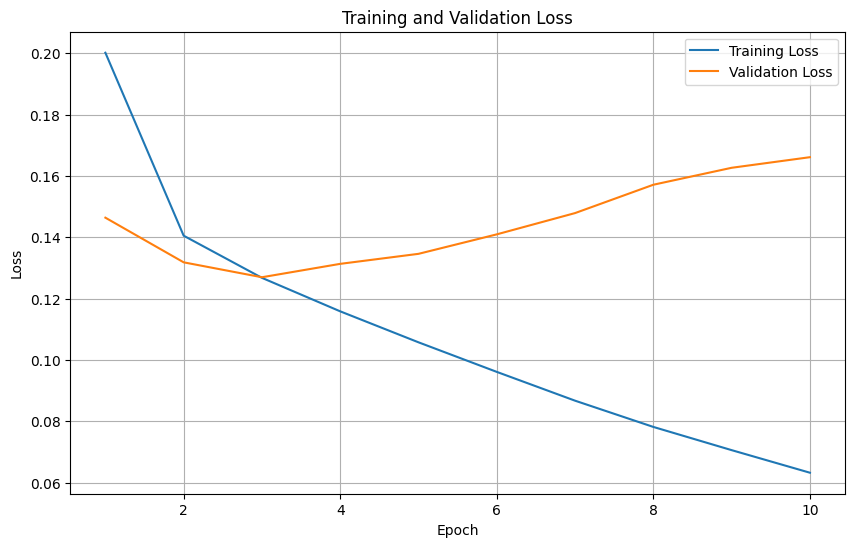

Model training completed and saved!


In [13]:
# Custom loss function for our multi-task learning
class MultiTaskLoss(nn.Module):
    def __init__(self, emotion_weight=1.0, metric_weight=0.5):
        super(MultiTaskLoss, self).__init__()
        self.emotion_weight = emotion_weight
        self.metric_weight = metric_weight
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.mse_loss = nn.MSELoss()
        
    def forward(self, outputs, emotion_labels, happy_labels=None, sad_labels=None, 
                neutral_labels=None, stress_labels=None):
        # Emotion classification loss
        emotion_loss = self.bce_loss(outputs['emotion_logits'], emotion_labels)
        
        total_loss = self.emotion_weight * emotion_loss
        
        # Add regression losses if labels are provided
        if happy_labels is not None:
            happy_loss = self.mse_loss(outputs['happy_score'], happy_labels)
            total_loss += self.metric_weight * happy_loss
            
        if sad_labels is not None:
            sad_loss = self.mse_loss(outputs['sad_score'], sad_labels)
            total_loss += self.metric_weight * sad_loss
            
        if neutral_labels is not None:
            neutral_loss = self.mse_loss(outputs['neutral_score'], neutral_labels)
            total_loss += self.metric_weight * neutral_loss
            
        if stress_labels is not None:
            stress_loss = self.mse_loss(outputs['stress_level'], stress_labels)
            total_loss += self.metric_weight * stress_loss
            
        return total_loss

# Training function
def train_model(model, train_loader, val_loader, device, num_epochs=5, learning_rate=2e-5):
    # Move model to device
    model = model.to(device)
    
    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Initialize loss function
    criterion = MultiTaskLoss()
    
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch in train_loader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                labels=labels
            )
            
            # Calculate loss using criterion instead of relying on model's loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            # Accumulate loss
            train_loss += loss.item()
        
        # Calculate average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                # Move batch to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                labels = batch['labels'].to(device)
                
                # Forward pass
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    labels=labels
                )
                
                # Calculate loss using criterion
                loss = criterion(outputs, labels)
                
                # Accumulate loss
                val_loss += loss.item()
        
        # Calculate average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model

# Main training script
def main():
    # Load the preprocessed data
    with open('emotion_columns.pkl', 'rb') as f:
        emotion_columns = pickle.load(f)
    
    # Load the dataset with the correct path
    df = pd.read_csv('/kaggle/input/goemotion-trimmed/goemotions_trimed.csv')
    
    # Split the dataset
    X = df['text'].values
    y = df[emotion_columns].values
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create model and tokenizer
    model_name = "microsoft/deberta-v3-small"  # You can change this to other models
    model, tokenizer = create_model_and_tokenizer(model_name, num_emotions=len(emotion_columns))
    
    # Create datasets
    train_dataset = EmotionDataset(X_train, y_train, tokenizer)
    val_dataset = EmotionDataset(X_val, y_val, tokenizer)
    
    # Create data loaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Train the model
    model = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        num_epochs=10,
        learning_rate=2e-5
    )
    
    # Save the model
    torch.save(model.state_dict(), 'emotion_stress_model.pt')
    tokenizer.save_pretrained('tokenizer')
    
    print("Model training completed and saved!")

if __name__ == "__main__":
    main()

In [14]:
import torch
import pickle
import numpy as np
from transformers import AutoTokenizer

# Import EmotionStressModel from the current notebook
# This is needed since we're using it in this cell
from __main__ import EmotionStressModel

# Function to calculate metrics from emotion predictions
def calculate_metrics(emotion_probs, emotion_columns, emotion_groups):
    # Get the indices of emotions in each group
    happy_indices = [emotion_columns.index(e) for e in emotion_groups['happy'] if e in emotion_columns]
    sad_indices = [emotion_columns.index(e) for e in emotion_groups['sad'] if e in emotion_columns]
    neutral_indices = [emotion_columns.index(e) for e in emotion_groups['neutral'] if e in emotion_columns]
    stress_indices = [emotion_columns.index(e) for e in emotion_groups['stress'] if e in emotion_columns]
    
    # Calculate metrics
    happy_score = min(10, int(10 * emotion_probs[happy_indices].mean() * 1.5))
    sad_score = min(10, int(10 * emotion_probs[sad_indices].mean() * 1.5))
    neutral_score = min(10, int(10 * emotion_probs[neutral_indices].mean() * 1.5))
    
    # Calculate stress level (more complex formula)
    # Base stress from stress emotions
    base_stress = emotion_probs[stress_indices].mean() * 70
    
    # Additional stress from the ratio of negative to positive emotions
    neg_pos_ratio = emotion_probs[sad_indices].sum() / (emotion_probs[happy_indices].sum() + 0.1)
    additional_stress = min(30, neg_pos_ratio * 15)
    
    stress_level = min(100, int(base_stress + additional_stress))
    
    return {
        'happy_score': happy_score,
        'sad_score': sad_score,
        'neutral_score': neutral_score,
        'stress_level': stress_level
    }

# Function for inference
def predict_emotions_and_stress(text, model, tokenizer, emotion_columns, emotion_groups, device):
    # Prepare the input
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=True,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    token_type_ids = encoding['token_type_ids'].to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Inference
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
    
    # Get emotion probabilities
    emotion_logits = outputs['emotion_logits']
    emotion_probs = torch.sigmoid(emotion_logits).cpu().numpy()[0]
    
    # Get emotion predictions (True/False)
    emotion_preds = (emotion_probs >= 0.5).astype(bool)
    
    # Get metric scores
    happy_score = outputs['happy_score'].cpu().numpy()[0][0]
    sad_score = outputs['sad_score'].cpu().numpy()[0][0]
    neutral_score = outputs['neutral_score'].cpu().numpy()[0][0]
    stress_level = outputs['stress_level'].cpu().numpy()[0][0]

    # Create results dictionary
    results = {
        'emotions': {emotion_columns[i]: emotion_preds[i] for i in range(len(emotion_columns))},
        'emotion_probs': {emotion_columns[i]: float(emotion_probs[i]) for i in range(len(emotion_columns))},
        'metrics': {
            'happy': min(10, int(happy_score * 10)),
            'sad': min(10, int(sad_score * 10)),
            'neutral': min(10, int(neutral_score * 10)),
            'stress': min(100, int(stress_level * 100))
        }
    }
    
    # Calculate metrics from emotion predictions as a backup/validation
    calculated_metrics = calculate_metrics(emotion_probs, emotion_columns, emotion_groups)
    results['calculated_metrics'] = calculated_metrics
    
    results['final_metrics'] = calculated_metrics
    
    return results

# Example usage
def test_model():
    # Load the model and tokenizer
    model_name = "microsoft/deberta-v3-small"
    
    # Load emotion columns and groups
    with open('emotion_columns.pkl', 'rb') as f:
        emotion_columns = pickle.load(f)
    with open('emotion_groups.pkl', 'rb') as f:
        emotion_groups = pickle.load(f)
    
    print("Emotion columns:", emotion_columns)
    print("Emotion groups:", emotion_groups)

    # Create model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EmotionStressModel(model_name, num_emotions=len(emotion_columns))
    
    # Load trained weights
    try:
        state_dict = torch.load('emotion_stress_model.pt')
        model.load_state_dict(state_dict)
        print("Model weights loaded successfully.")
    except Exception as e:
        print(f"Error loading model weights: {e}")
        print("Continuing with the base pre-trained model.")
    
    model.eval()  # Set the model to evaluation mode
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Test texts
    test_texts = [
        "I'm feeling really happy and excited about my new job!",
        "I'm so stressed out with all these deadlines and I can't sleep well.",
        "I'm feeling a bit sad today, but I'll be okay.",
        "I don't feel anything in particular right now.",
        "I fell today , got hurt , I cried, but then i received a gift so I got very exicited and Happy"
    ]
    
    # Make predictions
    for text in test_texts:
        print(f"\nText: {text}")
        results = predict_emotions_and_stress(text, model, tokenizer, emotion_columns, emotion_groups, device)
        
        print("\nEmotion Predictions:")
        for emotion, value in results['emotions'].items():
            if value:
                print(f"- {emotion}: {value}")
        
        print("\nMetrics:")
        print(f"Happy: {results['final_metrics']['happy_score']}/10")
        print(f"Sad: {results['final_metrics']['sad_score']}/10")
        print(f"Neutral: {results['final_metrics']['neutral_score']}/10")
        print(f"Stress Level: {results['final_metrics']['stress_level']}/100")
        print("-" * 50)

if __name__ == "__main__":
    test_model()

Emotion columns: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
Emotion groups: {'happy': ['admiration', 'amusement', 'approval', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief'], 'sad': ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'grief', 'remorse', 'sadness'], 'neutral': ['confusion', 'curiosity', 'realization', 'surprise', 'neutral'], 'stress': ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness']}


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-ec413538c1c5>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by 

Model weights loaded successfully.

Text: I'm feeling really happy and excited about my new job!

Emotion Predictions:
- excitement: True
- joy: True

Metrics:
Happy: 2/10
Sad: 0/10
Neutral: 0/10
Stress Level: 0/100
--------------------------------------------------

Text: I'm so stressed out with all these deadlines and I can't sleep well.

Emotion Predictions:

Metrics:
Happy: 0/10
Sad: 1/10
Neutral: 0/10
Stress Level: 35/100
--------------------------------------------------

Text: I'm feeling a bit sad today, but I'll be okay.

Emotion Predictions:
- sadness: True

Metrics:
Happy: 0/10
Sad: 1/10
Neutral: 0/10
Stress Level: 34/100
--------------------------------------------------

Text: I don't feel anything in particular right now.

Emotion Predictions:
- neutral: True

Metrics:
Happy: 0/10
Sad: 0/10
Neutral: 2/10
Stress Level: 2/100
--------------------------------------------------

Text: I fell today , got hurt , I cried, but then i received a gift so I got very exicited and Ha

In [10]:
# Create model_definition.py file using standard Python file operations
with open('model_definition.py', 'w') as f:
    f.write("""import torch
from torch import nn
from transformers import AutoModelForSequenceClassification

class EmotionStressModel(nn.Module):
    def __init__(self, model_name, num_emotions=28):
        super(EmotionStressModel, self).__init__()
        
        # Choose the base model with output_hidden_states=True in config
        config_kwargs = {
            'num_labels': num_emotions,
            'problem_type': 'multi_label_classification',
            'output_hidden_states': True
        }
        
        if 'deberta' in model_name.lower():
            self.base_model = AutoModelForSequenceClassification.from_pretrained(
                model_name, **config_kwargs
            )
        elif 'bert' in model_name.lower():
            self.base_model = AutoModelForSequenceClassification.from_pretrained(
                model_name, **config_kwargs
            )
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        # Get the hidden size from the base model config
        hidden_size = self.base_model.config.hidden_size
        
        # Additional regression heads for metrics
        self.happy_head = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.sad_head = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.neutral_head = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.stress_head = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        # Get the base model outputs
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=labels
        )
        
        # Get the hidden states from the last layer
        hidden_states = outputs.hidden_states[-1]
        
        # Use the [CLS] token representation for the regression heads
        cls_output = hidden_states[:, 0, :]
        
        # Get the emotion logits from the base model
        emotion_logits = outputs.logits
        
        # Calculate the metric scores (scale to the required ranges)
        happy_score = self.happy_head(cls_output) * 10  # Scale to 0-10
        sad_score = self.sad_head(cls_output) * 10      # Scale to 0-10
        neutral_score = self.neutral_head(cls_output) * 10  # Scale to 0-10
        stress_level = self.stress_head(cls_output) * 100  # Scale to 0-100
        
        return {
            'emotion_logits': emotion_logits,
            'happy_score': happy_score,
            'sad_score': sad_score,
            'neutral_score': neutral_score,
            'stress_level': stress_level,
            'loss': outputs.loss if labels is not None else None
        }
""")

print("model_definition.py file created successfully!")

model_definition.py file created successfully!


In [13]:
import torch
import pickle
import numpy as np
from transformers import AutoTokenizer
import os
import json
import pandas as pd

# Import your model definition
from model_definition import EmotionStressModel

def export_model_to_onnx():
    # Try to load the emotion columns and groups from pickle files
    # If they don't exist, recreate them from the dataset
    try:
        with open('emotion_columns.pkl', 'rb') as f:
            emotion_columns = pickle.load(f)
        with open('emotion_groups.pkl', 'rb') as f:
            emotion_groups = pickle.load(f)
        print("Loaded emotion data from pickle files")
    except FileNotFoundError:
        print("Pickle files not found, recreating emotion data from dataset")
        # Load the dataset
        df = pd.read_csv('/kaggle/input/goemotion-trimmed/goemotions_trimed.csv')
        
        # Get emotion columns (all columns except 'text')
        emotion_columns = df.columns[9:].tolist()
        
        # Define emotion groups
        happy_emotions = ['admiration', 'amusement', 'approval', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief']
        sad_emotions = ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'grief', 'remorse', 'sadness']
        neutral_emotions = ['confusion', 'curiosity', 'realization', 'surprise', 'neutral']
        stress_emotions = ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness']
        
        emotion_groups = {
            'happy': happy_emotions,
            'sad': sad_emotions,
            'neutral': neutral_emotions,
            'stress': stress_emotions
        }
        
        # Save the emotion columns and groups for future use
        with open('emotion_columns.pkl', 'wb') as f:
            pickle.dump(emotion_columns, f)
        with open('emotion_groups.pkl', 'wb') as f:
            pickle.dump(emotion_groups, f)
        
        print("Emotion data recreated and saved to pickle files")
    
    print(f"Number of emotion columns: {len(emotion_columns)}")
    print(f"Emotion columns: {emotion_columns}")
    
    # Create model and tokenizer
    model_name = "microsoft/deberta-v3-small"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EmotionStressModel(model_name, num_emotions=len(emotion_columns))
    
    # Load trained weights if they exist
    try:
        state_dict = torch.load('emotion_stress_model.pt')
        model.load_state_dict(state_dict)
        print("Model weights loaded successfully.")
    except Exception as e:
        print(f"Error loading model weights: {e}")
        print("Continuing with the base pre-trained model.")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create dummy input for ONNX export
    dummy_input_ids = torch.ones((1, 128), dtype=torch.long)
    dummy_attention_mask = torch.ones((1, 128), dtype=torch.long)
    dummy_token_type_ids = torch.zeros((1, 128), dtype=torch.long)
    
    # Export the model to ONNX
    torch.onnx.export(
        model,
        (dummy_input_ids, dummy_attention_mask, dummy_token_type_ids),
        "emotion_stress_model.onnx",
        export_params=True,
        opset_version=12,
        do_constant_folding=True,
        input_names=['input_ids', 'attention_mask', 'token_type_ids'],
        output_names=['emotion_logits', 'happy_score', 'sad_score', 'neutral_score', 'stress_level'],
        dynamic_axes={
            'input_ids': {0: 'batch_size', 1: 'sequence_length'},
            'attention_mask': {0: 'batch_size', 1: 'sequence_length'},
            'token_type_ids': {0: 'batch_size', 1: 'sequence_length'},
            'emotion_logits': {0: 'batch_size'},
            'happy_score': {0: 'batch_size'},
            'sad_score': {0: 'batch_size'},
            'neutral_score': {0: 'batch_size'},
            'stress_level': {0: 'batch_size'}
        }
    )
    
    print("Model exported to ONNX format: emotion_stress_model.onnx")
    
    # Save tokenizer vocabulary for use in Node.js
    tokenizer_config = {
        'vocab': tokenizer.get_vocab(),
        'max_length': 128,
        'padding': 'max_length',
        'truncation': True
    }
    
    # Save emotion columns and groups for use in Node.js
    with open('emotion_data.json', 'w') as f:
        json.dump({
            'emotion_columns': emotion_columns,
            'emotion_groups': emotion_groups
        }, f)
    
    print("Emotion data saved to emotion_data.json")
    
    # Create a test tokenization to verify
    test_text = "I'm feeling happy today!"
    encoding = tokenizer(
        test_text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=True,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    print("Example tokenization:")
    print(f"Text: {test_text}")
    print(f"Input IDs shape: {encoding['input_ids'].shape}")
    print(f"Attention Mask shape: {encoding['attention_mask'].shape}")
    print(f"Token Type IDs shape: {encoding['token_type_ids'].shape}")
    
    # Save example tokenization for reference in Node.js
    with open('example_tokenization.json', 'w') as f:
        json.dump({
            'text': test_text,
            'input_ids': encoding['input_ids'].tolist(),
            'attention_mask': encoding['attention_mask'].tolist(),
            'token_type_ids': encoding['token_type_ids'].tolist()
        }, f)
    
    print("Example tokenization saved to example_tokenization.json")

if __name__ == "__main__":
    export_model_to_onnx()

Pickle files not found, recreating emotion data from dataset
Emotion data recreated and saved to pickle files
Number of emotion columns: 28
Emotion columns: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-88add8a6d23d>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

Error loading model weights: [Errno 2] No such file or directory: 'emotion_stress_model.pt'
Continuing with the base pre-trained model.
Model exported to ONNX format: emotion_stress_model.onnx
Emotion data saved to emotion_data.json
Example tokenization:
Text: I'm feeling happy today!
Input IDs shape: torch.Size([1, 128])
Attention Mask shape: torch.Size([1, 128])
Token Type IDs shape: torch.Size([1, 128])
Example tokenization saved to example_tokenization.json
